<a href="https://colab.research.google.com/github/aayushsapkota9/jupyter-notebook/blob/main/pytorch/cnn/first_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


In [3]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 20



In [4]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Use transforms.compose method to reformat images for modeling,
# and save to variable all_transforms for later use
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])
# Create Training dataset
train_dataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             transform = all_transforms,
                                             download = True)

# Create Testing dataset
test_dataset = torchvision.datasets.CIFAR10(root = './data',
                                            train = False,
                                            transform = all_transforms,
                                            download=True)

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

100%|██████████| 170M/170M [00:04<00:00, 35.0MB/s]


In [6]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
#  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [7]:
model = ConvNeuralNet(num_classes)
model = model.to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

total_step = len(train_loader)

In [8]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
# Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/20], Loss: 1.8093
Epoch [2/20], Loss: 1.7195
Epoch [3/20], Loss: 1.2912
Epoch [4/20], Loss: 1.4396
Epoch [5/20], Loss: 1.7280
Epoch [6/20], Loss: 1.2673
Epoch [7/20], Loss: 0.9312
Epoch [8/20], Loss: 1.2343
Epoch [9/20], Loss: 1.2735
Epoch [10/20], Loss: 1.2000
Epoch [11/20], Loss: 1.0557
Epoch [12/20], Loss: 0.8952
Epoch [13/20], Loss: 0.9886
Epoch [14/20], Loss: 0.5955
Epoch [15/20], Loss: 0.8100
Epoch [16/20], Loss: 0.8750
Epoch [17/20], Loss: 0.7304
Epoch [18/20], Loss: 0.3569
Epoch [19/20], Loss: 0.5590
Epoch [20/20], Loss: 0.6341


In [9]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} train images: {} %'.format(50000, 100 * correct / total))

Accuracy of the network on the 50000 train images: 80.88 %


Saving the model

In [20]:
# Save the model weights to a file
import os
from google.colab import drive
drive.mount('/content/drive')

# Define the path for the directory
model_dir = "/content/drive/MyDrive/models"

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

torch.save(
    model.state_dict(),
    os.path.join(model_dir, "mnist_model.pth")
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reusing the model

In [21]:
# 1. Re-create the hollow structure
model = ConvNeuralNet(num_classes)

# 2. Load the weights into that structure
model.load_state_dict(
    torch.load("/content/drive/MyDrive/models/mnist_model.pth", map_location=device)
)
model = model.to(device)

# 3. Set to evaluation mode
model.eval()

ConvNeuralNet(
  (conv_layer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

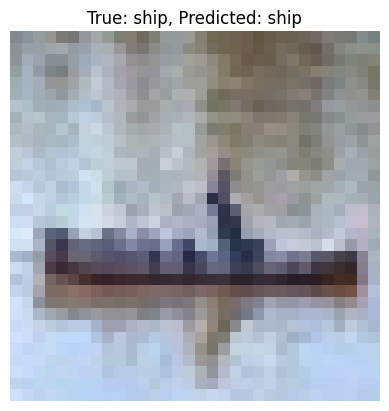

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define the CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get a random image from the test set
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move images and labels to the appropriate device
images = images.to(device)
labels = labels.to(device)

# Make a prediction
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Display the first image
img = images[0].cpu().numpy()
label = labels[0].item()
predicted_label = predicted[0].item()

# Unnormalize the image for display
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])
img = std.reshape(-1, 1, 1) * img + mean.reshape(-1, 1, 1)
img = np.clip(img, 0, 1)

plt.imshow(np.transpose(img, (1, 2, 0)))
plt.title(f"True: {classes[label]}, Predicted: {classes[predicted_label]}")
plt.axis('off')
plt.show()